# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%env CUDA_VISIBLE_DEVICES=0
%env BLISS_HOME=/home/yppatel/bliss

Modules to reload:
all-except-skipped

Modules to skip:

env: CUDA_VISIBLE_DEVICES=0
env: BLISS_HOME=/home/yppatel/bliss


In [11]:
%matplotlib inline 

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.substructure.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

In [5]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

0


# Encoder blend images

In [6]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="config"):
    cfg = compose("config", overrides=[])

In [7]:
dataset = instantiate(
    cfg.datasets.simulated,
    generate_device="cuda:0",
)

In [8]:
dataset.image_decoder.generate_residual = True
sample_batch_size = 16
tile_catalog = dataset.sample_prior(sample_batch_size, cfg.datasets.simulated.n_tiles_h, cfg.datasets.simulated.n_tiles_w)
packed_images, backgrounds = dataset.simulate_image_from_catalog(tile_catalog)
images = packed_images["global"]
residuals = packed_images["subhalos"]

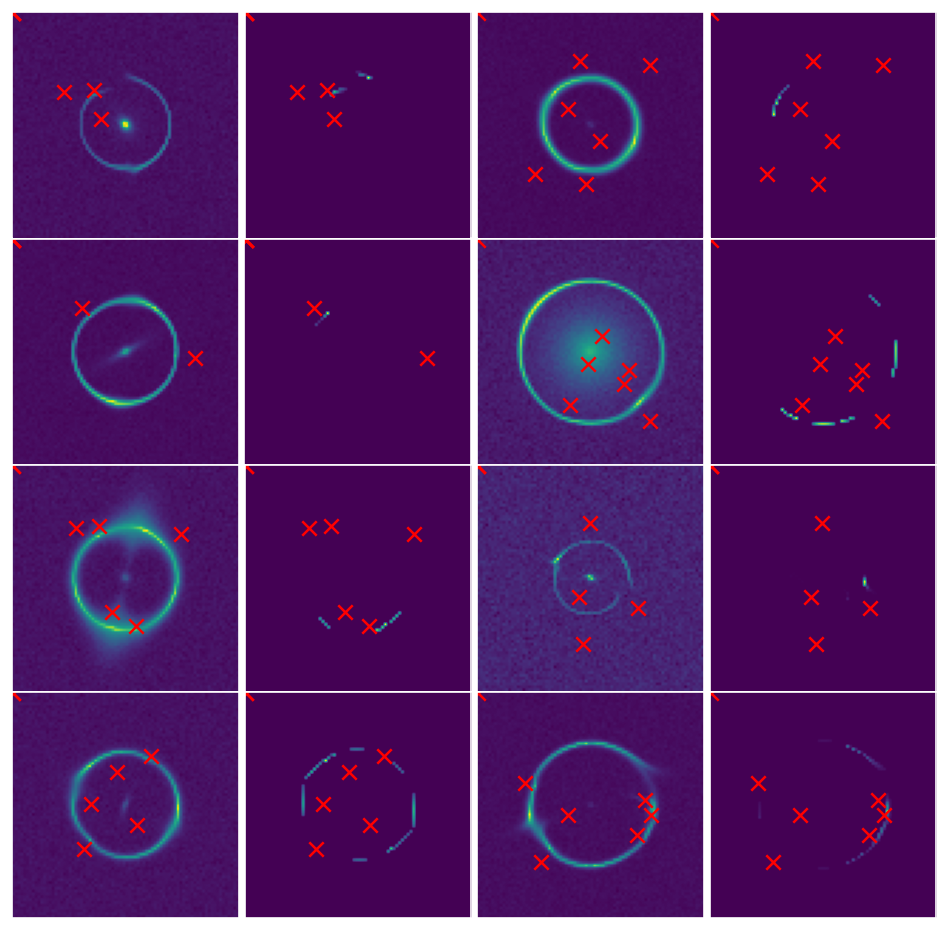

In [13]:
import numpy as np
full_true = tile_catalog["subhalos"].cpu().to_full_params()

plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(4, 4, figsize=(10, 10), dpi=120)
plt.subplots_adjust(wspace=0, hspace=0)
for i, image_pair in enumerate(zip(images[:8], residuals[:8])):
    image, residual = image_pair
    true_subhalo_pos = full_true.plocs[i,...]
        
    pos = 2 * i
    axs[pos // 4, pos % 4].imshow(np.log(image[0].cpu().numpy() + 2))
    axs[(pos + 1) // 4, (pos + 1) % 4].imshow(np.log(residual[0].cpu().numpy() + 2))
    for j in [pos, pos + 1]:
        axs[j // 4, j % 4].set_xticklabels([])
        axs[j // 4, j % 4].set_yticklabels([])
        axs[j // 4, j % 4].tick_params(left = False, bottom = False)
        axs[j // 4, j % 4].scatter(true_subhalo_pos[:, 0], true_subhalo_pos[:, 1], marker='x', color='r', s=75)